In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset Preparation

In [ ]:
!kaggle datasets download -d requiemonk/sentinel12-image-pairs-segregated-by-terrain

Dataset URL: https://www.kaggle.com/datasets/requiemonk/sentinel12-image-pairs-segregated-by-terrain
License(s): Attribution 4.0 International (CC BY 4.0)
100% 2.55G/2.55G [02:28<00:00, 21.9MB/s]
100% 2.55G/2.55G [02:28<00:00, 18.4MB/s]


In [ ]:
%%capture
!unzip sentinel12-image-pairs-segregated-by-terrain.zip
!rm -rf sentinel12-image-pairs-segregated-by-terrain.zip

In [2]:
import os
import shutil
opt = []
sar = []
root_dir = './v_2'
for dir in os.listdir(root_dir):
  path = os.path.join(root_dir, dir)
  s1, s2  = os.listdir(path)
  if s1 == 's2':
    for file in os.listdir(os.path.join(path, s1)):
      if file.endswith('.png'):
        opt.append(os.path.join(path, s1, file))
    for file in os.listdir(os.path.join(path, s2)):
      if file.endswith('.png'):
        sar.append(os.path.join(path, s2, file))
  if s1 == 's1':
    for file in os.listdir(os.path.join(path, s1)):
      if file.endswith('.png'):
        sar.append(os.path.join(path, s1, file))
    for file in os.listdir(os.path.join(path, s2)):
      if file.endswith('.png'):
        opt.append(os.path.join(path, s2, file))
opt = sorted(opt)
sar = sorted(sar)
print(len(opt), len(sar))


16000 16000


# **Denoising The SAR Images**

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from skimage import util
import numpy as np
from PIL import Image

class DnCNN(nn.Module):
    def __init__(self, depth=17, n_channels=64):
        super(DnCNN, self).__init__()
        layers = [nn.Conv2d(1, n_channels, kernel_size=3, padding=1), nn.ReLU(inplace=True)]
        for _ in range(depth - 2):
            layers.append(nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(n_channels))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(n_channels, 1, kernel_size=3, padding=1))
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        return x - self.dncnn(x)



In [ ]:
# Dataset Class for Noisy/Clean Image Pairs
class SARImageDataset(Dataset):
    def __init__(self, clean_images, transform=None):
        self.sar = clean_images[0]
        self.opt = clean_images[1]
        self.transform = transform

    def __len__(self):
        return len(self.sar)

    def __getitem__(self, idx):
        sar_img = self.sar[idx]
        opt_img = self.opt[idx]
        noisy_img = np.array(Image.open(sar_img).convert('L'))
        img = np.array(Image.open(opt_img).convert('L'))
        if self.transform:
            img = self.transform(img)
            noisy_img = self.transform(noisy_img)
        return noisy_img, img

# Load and preprocess data
images = [sar[:10000], opt[:10000]]
dataset = SARImageDataset(images, transform=ToTensor())

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, drop_last=True)


In [ ]:
from tqdm import tqdm

# Training the DnCNN Model
model = DnCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

def train(model, dataloader, num_epochs=15):
    model.train()
    for epoch in range(num_epochs):
        with tqdm(total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs} (Training)", unit="batch") as pbar:
            epoch_loss = 0
            for noisy_imgs, clean_imgs in dataloader:
                noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
                optimizer.zero_grad()
                denoised_imgs = model(noisy_imgs)
                loss = criterion(denoised_imgs, clean_imgs)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

                # Update progress bar
                pbar.set_postfix(loss=f"{epoch_loss/(pbar.n+1):.4f}")
                pbar.update(1)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}')

train(model, train_loader)


Epoch 1/15 (Training): 100%|██████████| 1000/1000 [08:31<00:00,  1.95batch/s, loss=0.0483]


Epoch [1/15], Loss: 0.0483


Epoch 1/15 (Training): 100%|██████████| 1000/1000 [08:31<00:00,  1.95batch/s, loss=0.0483]


Epoch [1/15], Loss: 0.0483


Epoch 2/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0428]


Epoch [2/15], Loss: 0.0428


Epoch 2/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0428]


Epoch [2/15], Loss: 0.0428


Epoch 3/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0411]


Epoch [3/15], Loss: 0.0411


Epoch 3/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0411]


Epoch [3/15], Loss: 0.0411


Epoch 4/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0402]


Epoch [4/15], Loss: 0.0402


Epoch 4/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0402]


Epoch [4/15], Loss: 0.0402


Epoch 5/15 (Training): 100%|██████████| 1000/1000 [08:41<00:00,  1.92batch/s, loss=0.0381]


Epoch [5/15], Loss: 0.0381


Epoch 5/15 (Training): 100%|██████████| 1000/1000 [08:41<00:00,  1.92batch/s, loss=0.0381]


Epoch [5/15], Loss: 0.0381


Epoch 6/15 (Training): 100%|██████████| 1000/1000 [08:41<00:00,  1.92batch/s, loss=0.0362]


Epoch [6/15], Loss: 0.0362


Epoch 6/15 (Training): 100%|██████████| 1000/1000 [08:41<00:00,  1.92batch/s, loss=0.0362]


Epoch [6/15], Loss: 0.0362


Epoch 7/15 (Training): 100%|██████████| 1000/1000 [08:41<00:00,  1.92batch/s, loss=0.0344]


Epoch [7/15], Loss: 0.0344


Epoch 7/15 (Training): 100%|██████████| 1000/1000 [08:41<00:00,  1.92batch/s, loss=0.0344]


Epoch [7/15], Loss: 0.0344


Epoch 8/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0328]


Epoch [8/15], Loss: 0.0328


Epoch 8/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0328]


Epoch [8/15], Loss: 0.0328


Epoch 9/15 (Training): 100%|██████████| 1000/1000 [08:41<00:00,  1.92batch/s, loss=0.0311]


Epoch [9/15], Loss: 0.0311


Epoch 9/15 (Training): 100%|██████████| 1000/1000 [08:41<00:00,  1.92batch/s, loss=0.0311]


Epoch [9/15], Loss: 0.0311


Epoch 10/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0303]


Epoch [10/15], Loss: 0.0303


Epoch 10/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0303]


Epoch [10/15], Loss: 0.0303


Epoch 11/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0298]


Epoch [11/15], Loss: 0.0298


Epoch 11/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0298]


Epoch [11/15], Loss: 0.0298


Epoch 12/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0292]


Epoch [12/15], Loss: 0.0292


Epoch 12/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0292]


Epoch [12/15], Loss: 0.0292


Epoch 13/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0288]


Epoch [13/15], Loss: 0.0288


Epoch 13/15 (Training): 100%|██████████| 1000/1000 [08:40<00:00,  1.92batch/s, loss=0.0288]


Epoch [13/15], Loss: 0.0288


Epoch 14/15 (Training): 100%|██████████| 1000/1000 [08:39<00:00,  1.92batch/s, loss=0.0285]


Epoch [14/15], Loss: 0.0285


Epoch 14/15 (Training): 100%|██████████| 1000/1000 [08:39<00:00,  1.92batch/s, loss=0.0285]


Epoch [14/15], Loss: 0.0285


Epoch 15/15 (Training): 100%|██████████| 1000/1000 [08:39<00:00,  1.92batch/s, loss=0.0279]

Epoch [15/15], Loss: 0.0279



Epoch 15/15 (Training): 100%|██████████| 1000/1000 [08:39<00:00,  1.92batch/s, loss=0.0279]

Epoch [15/15], Loss: 0.0279


In [ ]:
torch.save(model, 'dcnn.pth')

In [ ]:
import torch
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np

# Evaulating the denoising model
def test_accuracy(model, test_dataloader):
    total_psnr = 0
    total_ssim = 0
    num_images = 0
    model.eval()

    with torch.no_grad():
        for noisy_imgs, clean_imgs in tqdm(test_dataloader):
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
            denoised_imgs = model(noisy_imgs)

            denoised_imgs = denoised_imgs.cpu().numpy()
            clean_imgs = clean_imgs.cpu().numpy()

            # Iterate over the batch
            for i in range(clean_imgs.shape[0]):
                psnr = peak_signal_noise_ratio(clean_imgs[i, 0], denoised_imgs[i, 0], data_range=1.0)
                ssim = structural_similarity(clean_imgs[i, 0], denoised_imgs[i, 0], data_range=1.0)

                total_psnr += psnr
                total_ssim += ssim
                num_images += 1

    avg_psnr = total_psnr / num_images
    avg_ssim = total_ssim / num_images

    return avg_psnr, avg_ssim

In [ ]:
# Calculate PSNR and SSIM on the test set
avg_psnr, avg_ssim = test_accuracy(model, test_dataloader)
print(f'Average PSNR: {avg_psnr:.2f} dB')
print(f'Average SSIM: {avg_ssim:.4f}')

100%|██████████| 250/250 [00:50<00:00,  4.90it/s]

Average PSNR: 16.24 dB
Average SSIM: 0.2641
Average PSNR: 16.24 dB
Average SSIM: 0.2641


## Denoising with the denoising model

In [5]:
denoise_model = torch.load('dcnn_model.pth', map_location=device)

/tmp/ipykernel_59501/4292788897.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  denoise_model = torch.load('dcnn_model.pth', map_location=device)


In [6]:
from tqdm import tqdm
from torchvision import transforms
from PIL import Image

def prediction(model, sar_images):
    model.eval()
    predictedimages = []
    with torch.no_grad():
        for noisy_imgs in tqdm(sar_images):
            noisy_imgs = np.array(Image.open(noisy_imgs).convert('L'))
            noisy_imgs = transforms.ToTensor()(noisy_imgs)
            noisy_imgs = noisy_imgs.unsqueeze(0).to(device)
            denoised_imgs = model(noisy_imgs)
            img = denoised_imgs.squeeze(0).cpu().numpy()
            img = (img[0] * 255).astype('uint8')
            predictedimages.append(img)
    return predictedimages

gray_images = prediction(denoise_model, sar)


100%|██████████| 16000/16000 [02:25<00:00, 109.82it/s]


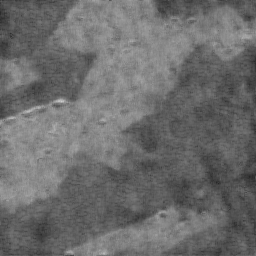

In [9]:
Image.fromarray(gray_images[78])

# **Implementing Colorization Model**

In [10]:
import cv2
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt



## Preparing dataset for colorization model

In [11]:
from torchvision import transforms
from skimage.color import rgb2lab, lab2rgb

def rgb_to_lab(img):

    img_lab = rgb2lab(img).astype("float32")
    img_lab = transforms.ToTensor()(img_lab)
    L_channel = img_lab[[0], ...]
    ab_channels = img_lab[[1, 2], ...]
    # scale between -1 to 1
    L_channel = 2 * (L_channel - (0)) / (100 - (0)) - 1
    ab_channels = 2 * (ab_channels - (-128)) / (127 - (-128)) - 1

    return L_channel, ab_channels

In [12]:
def create_patches(img, patch_size=224):
    patches = []
    h, w = img.shape[1:]

    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = img[:, i:i + patch_size, j:j + patch_size]
            if patch.shape[1:] == (patch_size, patch_size):
                patches.append(patch)

    return patches

In [13]:
class ColorizationDataset(Dataset):
    def __init__(self, grayscale_dir, color_dir, transform=None, patch_size=224):
        self.grayscale_dir = grayscale_dir
        self.color_dir = color_dir
        self.transform = transform
        self.patch_size = patch_size

    def __len__(self):
        return len(self.grayscale_dir)

    def __getitem__(self, idx):

        gray_img = self.grayscale_dir[idx]
        color_img = np.array(Image.open(self.color_dir[idx]))

        # resize image to 224
        gray_img = cv2.resize(gray_img, (224, 224))
        color_img = cv2.resize(color_img, (224, 224))

        # Convert to Lab color space
        gray_L, gray_ab = rgb_to_lab(cv2.merge((gray_img, gray_img, gray_img)))
        L_channel, ab_channels = rgb_to_lab(color_img)

        # # convert gray in range of -1 to 1
        gray_img = gray_img / 2.55
        gray_img = (gray_img - (0)) / (100 - (0)) * 2 - 1
        gray_img = transforms.ToTensor()(gray_img)
        gray_img = gray_img.type(torch.float32)


        return gray_L, ab_channels


In [14]:
dataset = ColorizationDataset(gray_images[:8000], opt[:8000])

# Split dataset into training and validation
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, drop_last=True)




In [15]:
# Load a batch and print the shapes of the patches
for L_patches, ab_patches in train_loader:
    print(f"L_patches shape: {L_patches.shape}")
    print(f"ab_patches shape: {ab_patches.shape}")
    print(L_patches[0])
    break

L_patches shape: torch.Size([32, 1, 224, 224])
ab_patches shape: torch.Size([32, 2, 224, 224])
tensor([[[-0.3365, -0.5116, -0.4937,  ..., -0.0232, -0.0955, -0.0472],
         [-0.3708, -0.4847, -0.4759,  ..., -0.0794, -0.1117, -0.0713],
         [-0.3881, -0.4759, -0.4405,  ..., -0.1525, -0.1199, -0.1362],
         ...,
         [-0.2603, -0.2603, -0.2687,  ..., -0.0632, -0.0232, -0.0073],
         [-0.2855, -0.2687, -0.2435,  ..., -0.0312, -0.0472,  0.0007],
         [-0.0794, -0.1362, -0.2268,  ..., -0.0472, -0.0392, -0.0232]]])


## Implementing the Encoder

In [16]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet50_Weights, DenseNet121_Weights

class EnsembleEncoder(nn.Module):
    def __init__(self):
        super(EnsembleEncoder, self).__init__()

        # Load pre-trained ResNet50 and DenseNet121
        self.resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.densenet121 = models.densenet121(weights=DenseNet121_Weights.DEFAULT)

        self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])
        # self.densenet121 = nn.Sequential(*list(self.densenet121.children())[:-1])
        self.densenet121.classifier = nn.Identity()


        # Custom layers for fusion
        self.conv1x1_resnet50 = nn.ModuleList([
            nn.Conv2d(256, 128, kernel_size=1),
            nn.Conv2d(512, 256, kernel_size=1),
            nn.Conv2d(1024, 512, kernel_size=1),
            nn.Conv2d(2048, 1024, kernel_size=1)
        ])

        self.conv1x1_densenet121 = nn.ModuleList([
            nn.Conv2d(256, 128, kernel_size=1),
            nn.Conv2d(512, 256, kernel_size=1),
            nn.Conv2d(1024, 512, kernel_size=1),
            nn.Conv2d(1024, 1024, kernel_size=1)
        ])

        self.fusion_blocks = nn.ModuleList([
            self.fusion_block(128, 128),
            self.fusion_block(256, 256),
            self.fusion_block(512, 512),
            self.fusion_block(1024, 1024)
        ])

    # Fusion block
    def fusion_block(self, in_channels_resnet, in_channels_densenet):
        return nn.Sequential(
            nn.Conv2d(in_channels_resnet + in_channels_densenet, in_channels_resnet, kernel_size=1),
            nn.BatchNorm2d(in_channels_resnet),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Forward pass through ResNet50
        resnet_features = []
        resnet_input = x
        for i, layer in enumerate(self.resnet50.children()):
            resnet_input = layer(resnet_input)
            if i in [4, 5, 6, 7]:  # Extract features after specific layers
                resnet_features.append(self.conv1x1_resnet50[i-4](resnet_input))

        # Forward pass through DenseNet121
        densenet_features = []
        idx = 0
        densenet_input = x
        for i, layer in enumerate(self.densenet121.features):
            densenet_input = layer(densenet_input)
            if i in [ 4, 6, 8, 11]:
                densenet_features.append(self.conv1x1_densenet121[idx](densenet_input))
                idx += 1


        fused_features = []
        for i in range(4):
            fused = torch.cat((resnet_features[i], densenet_features[i]), dim=1)
            fused = self.fusion_blocks[i](fused)
            fused_features.append(fused)

        return fused_features


## Implementing the Decoder

In [17]:
import torch
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        # Decoder block 1: Takes input from Fusion Block 4
        self.decode1 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 7x7 -> 14x14
        )

        # Decoder block 2: Takes input from Decoder Block 1 + Fusion Block 3 (512 + 512 channels)
        self.decode2 = nn.Sequential(
            nn.Conv2d(512 + 512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 14x14 -> 28x28
        )

        # Decoder block 3: Takes input from Decoder Block 2 + Fusion Block 2 (256 + 256 channels)
        self.decode3 = nn.Sequential(
            nn.Conv2d(256 + 256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 28x28 -> 56x56
        )

        # Decoder block 4: Takes input from Decoder Block 3 + Fusion Block 1 (128 + 128 channels)
        self.decode4 = nn.Sequential(
            nn.Conv2d(128 + 128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 56x56 -> 112x112
        )

        # Final decoder block: Reduce to 2 channels (ab channels)
        self.decode5 = nn.Sequential(
            nn.Conv2d(64, 2, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 112x112 -> 224x224
        )

    def forward(self, features_7x7, features_14x14, features_28x28, features_56x56):
        x = self.decode1(features_7x7)
        x = torch.cat([x, features_14x14], dim=1)
        x = self.decode2(x)

        x = torch.cat([x, features_28x28], dim=1)
        x = self.decode3(x)

        x = torch.cat([x, features_56x56], dim=1)
        x = self.decode4(x)

        output = self.decode5(x)

        return output


## Checking our model

In [18]:
import torch
import torch.nn as nn

class ColorizationModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(ColorizationModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        features_56x56, features_28x28, features_14x14, features_7x7 = self.encoder(x)

        output = self.decoder(features_7x7, features_14x14, features_28x28, features_56x56)

        return output

encoder = EnsembleEncoder()
decoder = Decoder()

model = ColorizationModel(encoder, decoder)

# input data
L_patches = torch.randn(1, 3, 224, 224)

output = model(L_patches)

print("Output shape:", output.shape)  # output shape should be [1, 2, 224, 224]


Output shape: torch.Size([1, 2, 224, 224])


## Training the model

In [19]:
%%time
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = EnsembleEncoder()
decoder = Decoder()

# Freeze the encoder parameters as they are not to be trained
for param in encoder.parameters():
    param.requires_grad = False


model = ColorizationModel(encoder, decoder).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 15
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Training)")

    for i, (L_batch, ab_batch) in enumerate(train_bar):
        L, ab = L_batch.to(device), ab_batch.to(device)
        L = L.repeat(1, 3, 1, 1)

        optimizer.zero_grad()

        output = model(L)

        loss = criterion(output, ab)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        train_bar.set_postfix(loss=f"{running_loss/(i+1):.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)")

    with torch.no_grad():
        for i, (L_batch, ab_batch) in enumerate(val_bar):
            L, ab = L_batch.to(device), ab_batch.to(device)
            L = L.repeat(1, 3, 1, 1)

            output = model(L)
            loss = criterion(output, ab)
            val_loss += loss.item()

            val_bar.set_postfix(loss=f"{val_loss/(i+1):.4f}")

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model, 'best_colorization_model.pth')

print("Training complete.")

Epoch 1/15 (Validation): 100%|██████████| 40/40 [00:07<00:00,  5.20it/s, loss=0.0036]


Epoch 1/15, Training Loss: 0.0058, Validation Loss: 0.0036


Epoch 2/15 (Validation): 100%|██████████| 40/40 [00:07<00:00,  5.14it/s, loss=0.0033]


Epoch 2/15, Training Loss: 0.0034, Validation Loss: 0.0033


Epoch 3/15 (Validation): 100%|██████████| 40/40 [00:08<00:00,  4.88it/s, loss=0.0034]


Epoch 3/15, Training Loss: 0.0033, Validation Loss: 0.0034


Epoch 4/15 (Validation): 100%|██████████| 40/40 [00:08<00:00,  4.98it/s, loss=0.0032]


Epoch 4/15, Training Loss: 0.0031, Validation Loss: 0.0032


Epoch 5/15 (Validation): 100%|██████████| 40/40 [00:08<00:00,  4.78it/s, loss=0.0031]


Epoch 5/15, Training Loss: 0.0030, Validation Loss: 0.0031


Epoch 6/15 (Validation): 100%|██████████| 40/40 [00:07<00:00,  5.09it/s, loss=0.0031]


Epoch 6/15, Training Loss: 0.0030, Validation Loss: 0.0031


Epoch 7/15 (Validation): 100%|██████████| 40/40 [00:07<00:00,  5.14it/s, loss=0.0030]


Epoch 7/15, Training Loss: 0.0028, Validation Loss: 0.0030


Epoch 8/15 (Validation): 100%|██████████| 40/40 [00:08<00:00,  5.00it/s, loss=0.0035]


Epoch 8/15, Training Loss: 0.0028, Validation Loss: 0.0035


Epoch 9/15 (Validation): 100%|██████████| 40/40 [00:07<00:00,  5.01it/s, loss=0.0034]


Epoch 9/15, Training Loss: 0.0027, Validation Loss: 0.0034


Epoch 10/15 (Validation): 100%|██████████| 40/40 [00:07<00:00,  5.10it/s, loss=0.0030]


Epoch 10/15, Training Loss: 0.0025, Validation Loss: 0.0030


Epoch 11/15 (Validation): 100%|██████████| 40/40 [00:07<00:00,  5.15it/s, loss=0.0032]


Epoch 11/15, Training Loss: 0.0024, Validation Loss: 0.0032


Epoch 12/15 (Validation): 100%|██████████| 40/40 [00:07<00:00,  5.00it/s, loss=0.0031]


Epoch 12/15, Training Loss: 0.0025, Validation Loss: 0.0031


Epoch 13/15 (Validation): 100%|██████████| 40/40 [00:07<00:00,  5.04it/s, loss=0.0030]


Epoch 13/15, Training Loss: 0.0023, Validation Loss: 0.0030


Epoch 14/15 (Validation): 100%|██████████| 40/40 [00:07<00:00,  5.13it/s, loss=0.0030]


Epoch 14/15, Training Loss: 0.0023, Validation Loss: 0.0030


Epoch 15/15 (Validation): 100%|██████████| 40/40 [00:07<00:00,  5.12it/s, loss=0.0030]

Epoch 15/15, Training Loss: 0.0022, Validation Loss: 0.0030
Training complete.
CPU times: user 5min 58s, sys: 21.7 s, total: 6min 19s
Wall time: 9min 35s


In [20]:
torch.cuda.empty_cache()

## Preparing data for prediction

In [21]:
import os
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.color import rgb2lab

class ColorizationDatasetNew(Dataset):
    def __init__(self, gray_img, opt_image, transform=None):
        self.gray_image = gray_img
        self.opt_image = opt_image
        self.transform = transform

    def __len__(self):
        return len(self.gray_image)

    def __getitem__(self, idx):
        gray_img = self.gray_image[idx]
        color_img = np.array(Image.open(self.opt_image[idx]))

        gray_img = cv2.resize(gray_img, (224, 224))
        color_img = cv2.resize(color_img, (224, 224))

        gray_L, _ = rgb_to_lab(cv2.merge([gray_img, gray_img, gray_img]))
        L_channel, ab_channels = rgb_to_lab(color_img)

        gray_img = gray_img / 2.55
        gray_img = (gray_img - (0)) / (100 - (0)) * 2 - 1
        gray_img = transforms.ToTensor()(gray_img)
        gray_img = gray_img.type(torch.float32)

        return gray_L, L_channel, ab_channels

# Create the test dataset for prediction
dataset_new = ColorizationDatasetNew(gray_images, opt)

test_set_new = DataLoader(dataset_new, batch_size=32, shuffle=False, num_workers=2)

In [22]:
for L,real_L, ab in test_set_new:
    print(real_L.shape)
    print(L.shape)
    print(ab.shape)
    print(L[0][0])
    break

torch.Size([32, 1, 224, 224])
torch.Size([32, 1, 224, 224])
torch.Size([32, 2, 224, 224])
tensor([[-0.0874,  0.0952,  0.1418,  ..., -0.1443, -0.0794,  0.0560],
        [ 0.2034,  0.2034,  0.1650,  ..., -0.0713, -0.0472,  0.0717],
        [ 0.2188,  0.1650,  0.1263,  ..., -0.0632, -0.0392,  0.0717],
        ...,
        [-0.2603, -0.2102, -0.1771,  ...,  0.0560,  0.1108,  0.0324],
        [-0.2771, -0.2185, -0.2102,  ...,  0.0007,  0.0481, -0.0713],
        [-0.2019, -0.2352, -0.3194,  ...,  0.0007,  0.0324, -0.2185]])


## Inference

In [29]:
# Get a batch from the test loader
dataiter = iter(test_set_new)
L_batch,real_L, ab_batch = next(dataiter)
L_batch,real_L, ab_batch = next(dataiter)
L_batch, real_L, ab_batch = L_batch.to(device),real_L.to(device), ab_batch.to(device)
L_batch = L_batch.repeat(1, 3, 1, 1)

model.eval()
with torch.no_grad():
    predicted_ab = model(L_batch)


In [30]:
predicted_ab[0][0]

tensor([[-0.0318, -0.0354, -0.0427,  ..., -0.0051, -0.0046, -0.0044],
        [-0.0412, -0.0435, -0.0480,  ..., -0.0083, -0.0071, -0.0065],
        [-0.0598, -0.0595, -0.0588,  ..., -0.0147, -0.0120, -0.0107],
        ...,
        [-0.0743, -0.0747, -0.0753,  ..., -0.0041, -0.0098, -0.0127],
        [-0.0635, -0.0646, -0.0669,  ..., -0.0029, -0.0061, -0.0077],
        [-0.0580, -0.0596, -0.0628,  ..., -0.0022, -0.0042, -0.0051]],
       device='cuda:0')

In [31]:
L_batch = L_batch[:, 0, :, :]
L_batch = L_batch.unsqueeze(1)

L_batch = (L_batch + 1) * 0.5 * 100
real_L = (real_L + 1) * 0.5 * 100
predicted_ab = ((predicted_ab + 1) * 0.5 * (127 + 128)) - 128
ab_batch = ((ab_batch + 1) * 0.5 * (127 + 128)) - 128

# Combine L and ab channels
predicted_lab = torch.cat([L_batch, predicted_ab], dim=1)
real_lab = torch.cat([L_batch, ab_batch], dim=1)
actual_lab = torch.cat([real_L, ab_batch], dim=1)
mixed_lab = torch.cat([real_L, predicted_ab], dim=1)

predicted_lab = predicted_lab.cpu().numpy()
real_lab = real_lab.cpu().numpy()
actual_lab = actual_lab.cpu().numpy()
mixed_lab = mixed_lab.cpu().numpy()

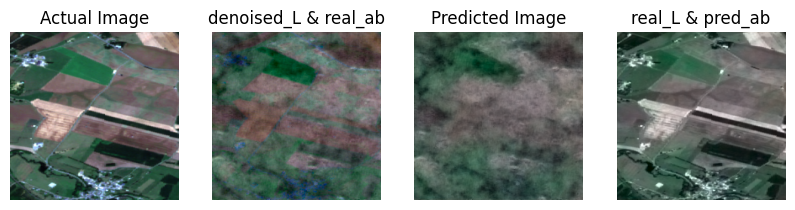

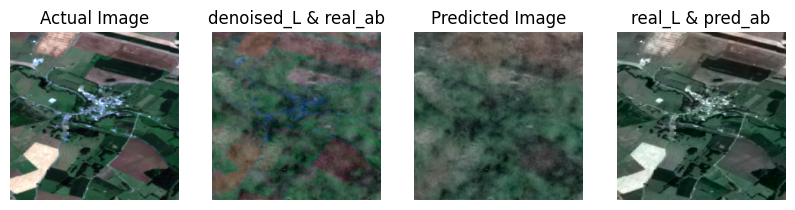

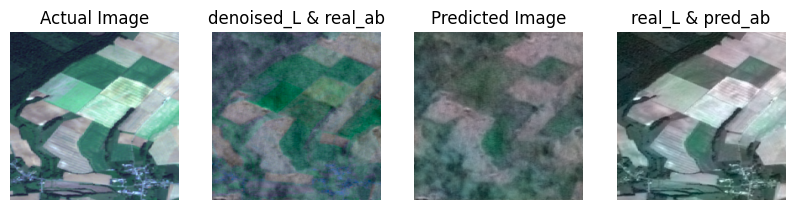

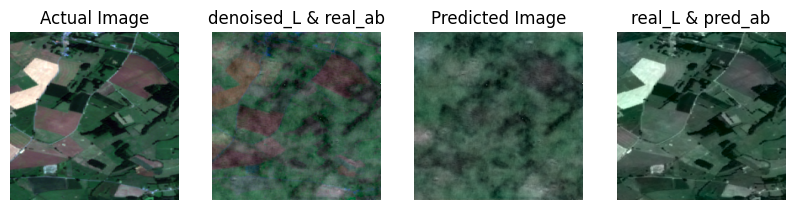

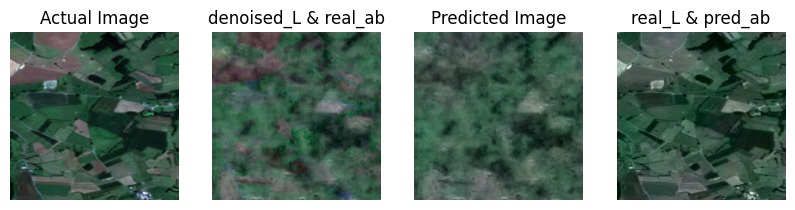

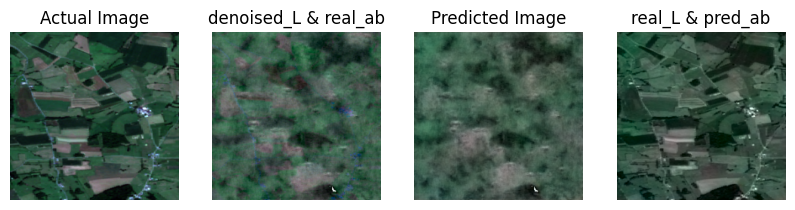

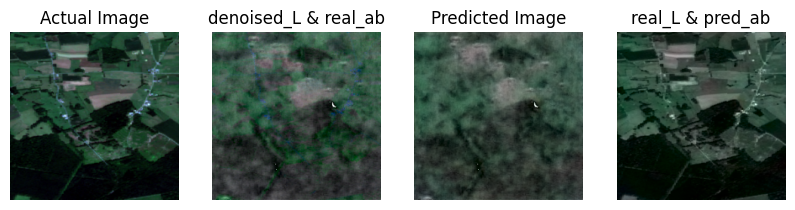

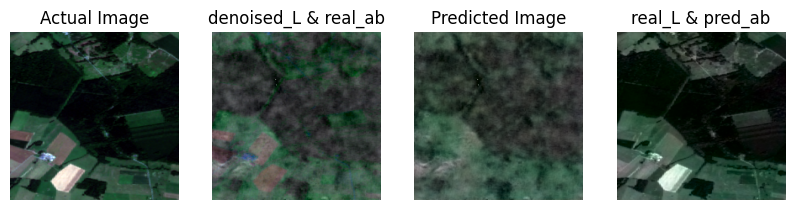

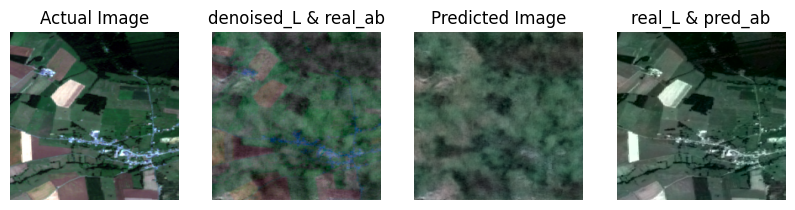

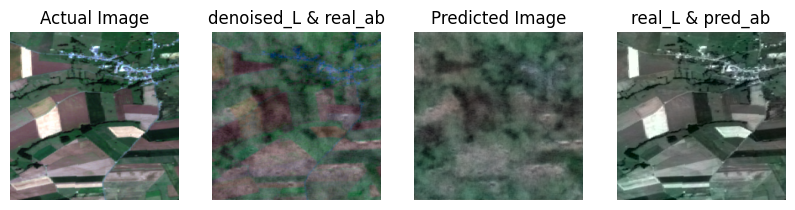

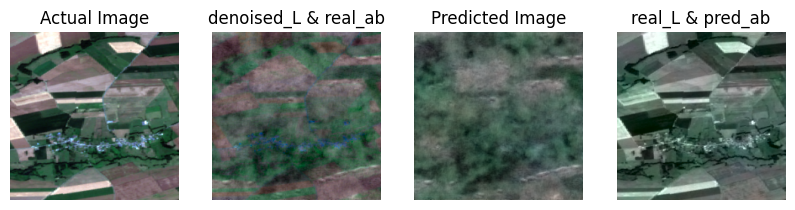

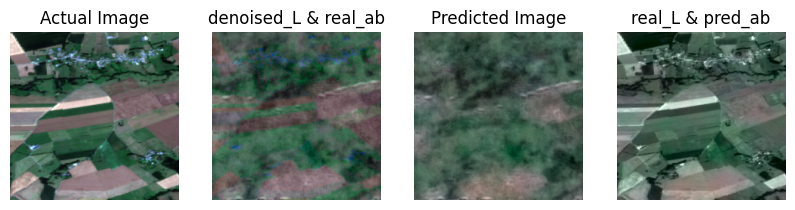

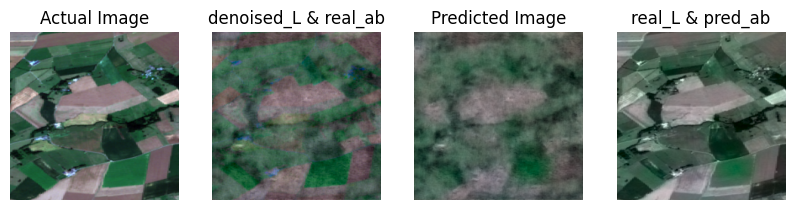

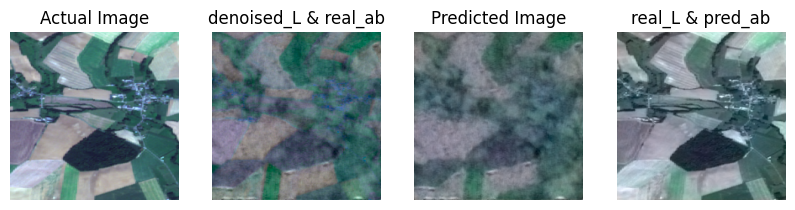

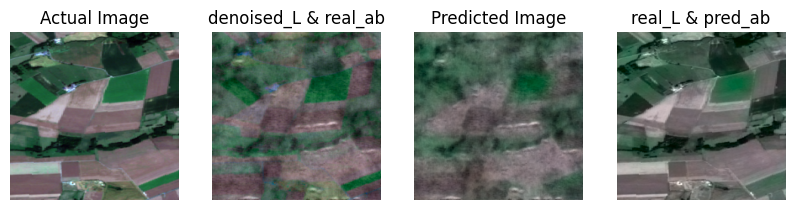

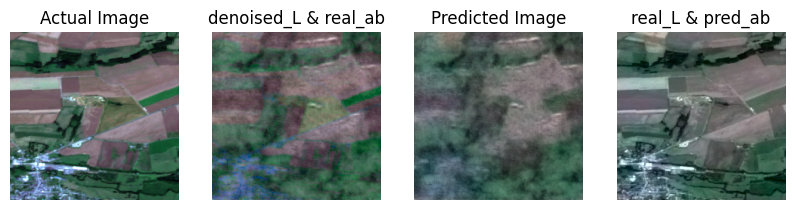

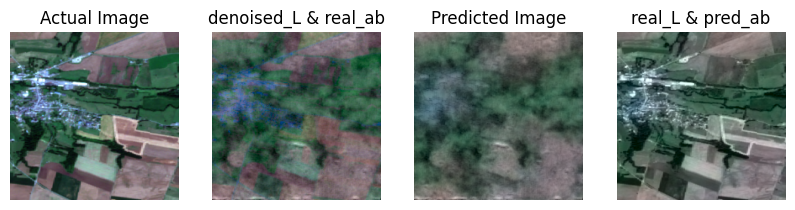

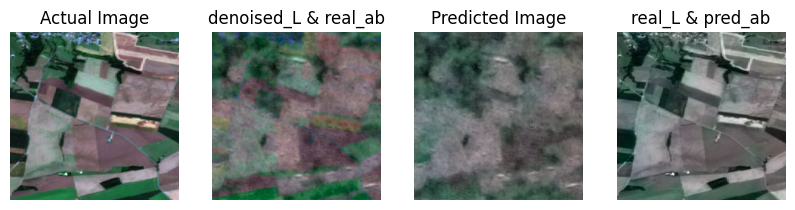

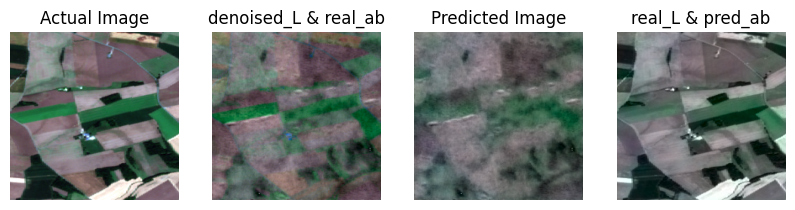

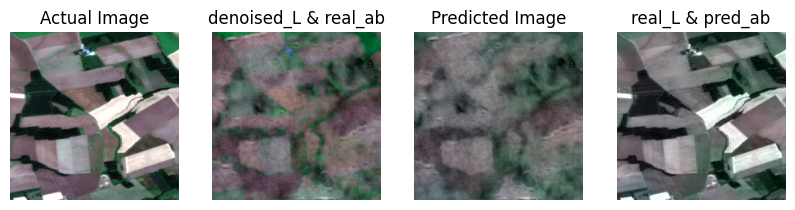

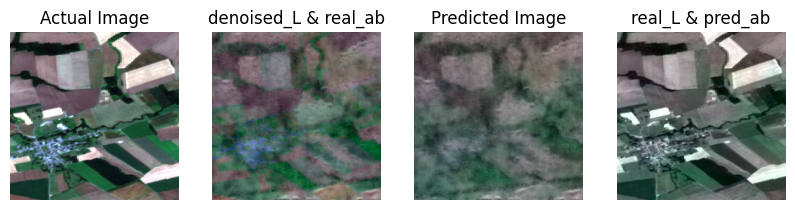

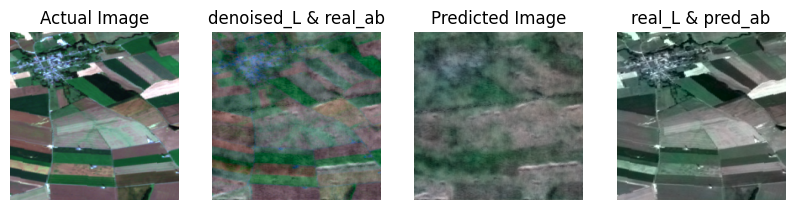

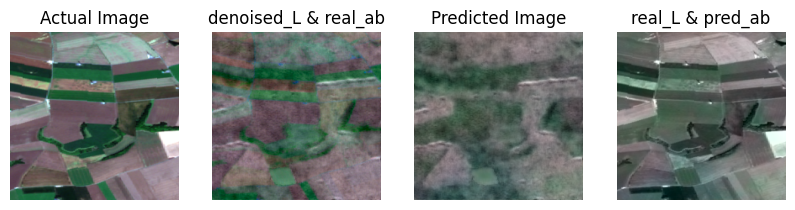

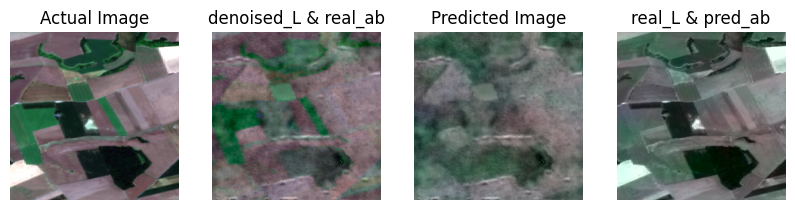

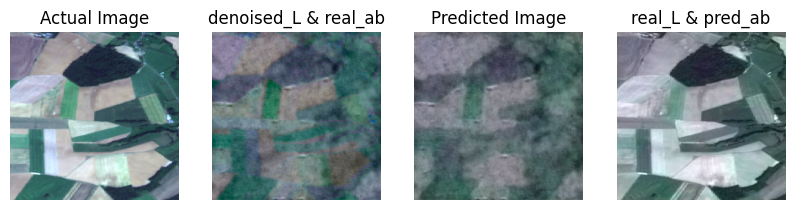

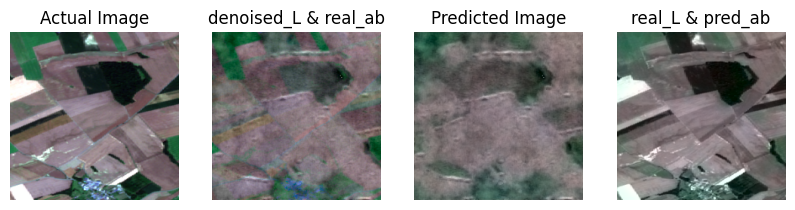

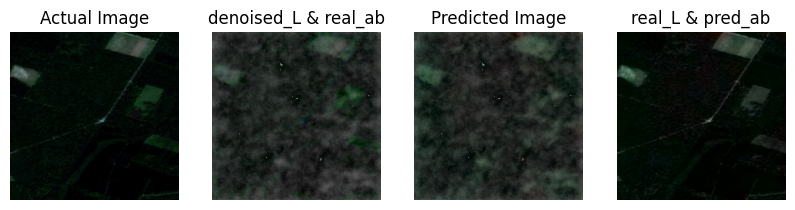

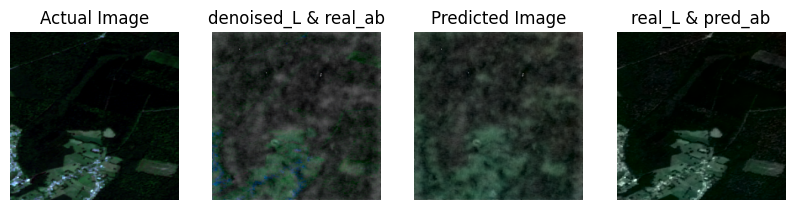

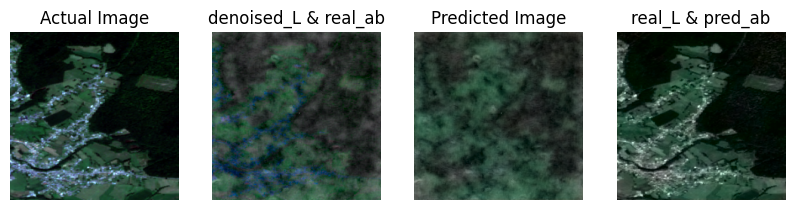

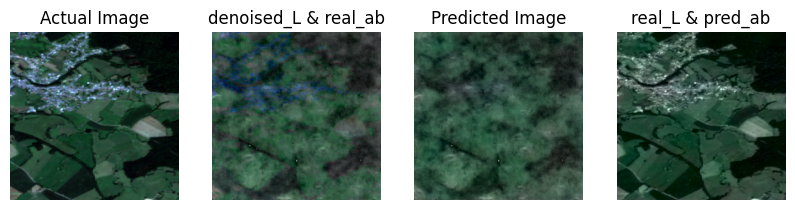

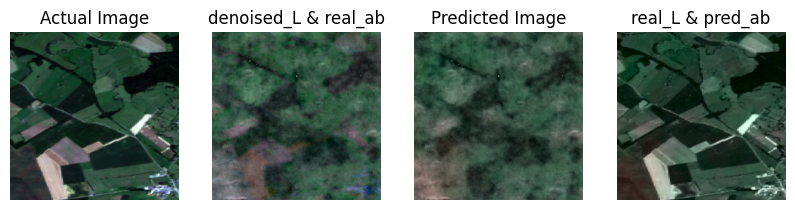

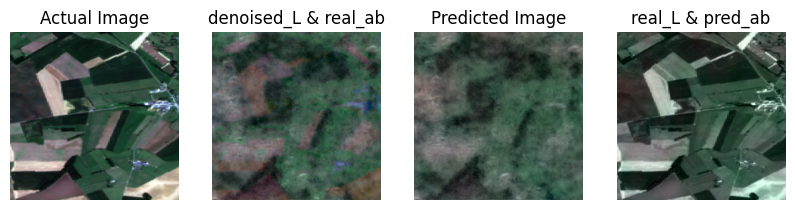

In [32]:
import numpy as np
from skimage.color import lab2rgb
import matplotlib.pyplot as plt
import cv2


# Iterate over the batch
for i in range(32):

    lab_image = predicted_lab[i]
    real_img = real_lab[i]
    actual_img = actual_lab[i]
    mixed_img = mixed_lab[i]

    # Transpose to (height, width, 3) for skimage
    lab_image = lab_image.transpose(1, 2, 0).astype(np.float64)
    real_img = real_img.transpose(1, 2, 0).astype(np.float64)
    actual_img = actual_img.transpose(1, 2, 0).astype(np.float64)
    mixed_img = mixed_img.transpose(1, 2, 0).astype(np.float64)

    # Convert Lab to RGB using skimage.color.lab2rgb
    rgb_image = lab2rgb(lab_image)
    real_rgb = lab2rgb(real_img)
    actual_rgb = lab2rgb(actual_img)
    mixed_rgb = lab2rgb(mixed_img)

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 4, 1)
    plt.imshow(actual_rgb)
    plt.axis('off')
    plt.title('Actual Image')
    plt.subplot(1, 4, 2)
    plt.imshow(real_rgb)
    plt.axis('off')
    plt.title('denoised_L & real_ab')
    plt.subplot(1, 4, 3)
    plt.imshow(rgb_image)
    plt.title('Predicted Image')
    plt.axis('off')
    plt.subplot(1, 4, 4)
    plt.imshow(mixed_rgb)
    plt.title('real_L & pred_ab')
    plt.axis('off')
    plt.show()

## Evaulting the Model

In [27]:
def prediction(model, test_loader):    
    model.eval()
    original_images = []
    predicted_images = []

    for L_batch, real_L, ab_batch in tqdm(test_loader):
        L_batch,real_L, ab_batch = L_batch.to(device), real_L.to(device), ab_batch.to(device)
        input = L_batch.repeat(1, 3, 1, 1)

        with torch.no_grad():            

            predicted_ab = model(input)
            # predicted_ab = model(input)

        L_batch = (L_batch + 1) * 0.5 * 100
        real_L = (real_L + 1) * 0.5 * 100
        predicted_ab = ((predicted_ab + 1) * 0.5 * (127 + 128)) - 128
        ab_batch = ((ab_batch + 1) * 0.5 * (127 + 128)) - 128

        # Combine L and ab channels
        predicted_lab = torch.cat([L_batch, predicted_ab], dim=1)
        actual_lab = torch.cat([real_L, ab_batch], dim=1)

        predicted_lab = predicted_lab.cpu().numpy()
        actual_lab = actual_lab.cpu().numpy()

        predicted_images.extend(predicted_lab)
        original_images.extend(actual_lab)

    return original_images, predicted_images

original_images, predicted_images = prediction(model, test_set_new)

100%|██████████| 500/500 [01:33<00:00,  5.34it/s]


In [28]:
import warnings

warnings.filterwarnings('ignore')

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.color import lab2rgb
import numpy as np

def evaluate_model(original_images, predicted_images):

    total_ssim = 0.0
    total_psnr = 0.0
    total_samples = 0
    for original_img, predicted_img in tqdm(zip(original_images, predicted_images)):
        original_img = lab2rgb(original_img.transpose(1, 2, 0))
        predicted_img = lab2rgb(predicted_img.transpose(1, 2, 0))

        ssim_value = ssim(original_img, predicted_img, multichannel=True, channel_axis=2, data_range=1.0)
        psnr_value = psnr(original_img, predicted_img, data_range=1.0)
        total_ssim += ssim_value
        total_psnr += psnr_value
        total_samples += 1

    average_ssim = total_ssim / total_samples
    average_psnr = total_psnr / total_samples

    return average_ssim, average_psnr

ssim_value, psnr_value = evaluate_model(original_images, predicted_images)
print(f"Average SSIM: {ssim_value:.4f}")
print(f"Average PSNR: {psnr_value:.4f}")



16000it [03:05, 86.18it/s]


Average SSIM: 0.2314
Average PSNR: 14.4466
